# Facebook ProphetとSparkを活用した高精度需要予測

時系列データ予測技術の進化は、小売業界においてより信頼性のある需要予測を可能としました。今や、適切な精度およびスピードで予測値を提供し、ビジネスサイドで商品在庫を正確に調整できる様にすることが、新たな課題になっています。これらの課題に直面している多くの企業が、[Apache Spark™](https://databricks.com/spark/about)と[Facebook Prophet](https://facebook.github.io/prophet/)を活用することで、これまでのソリューションにあった精度およびスケーラビリティの課題を克服しています。

本ノートブックでは、時系列データ予測の重要性を議論し、サンプル時系列データの可視化を行います。そして、簡単なモデルを構築してFacebook Prophetの使用法を説明します。単一のモデル構築に慣れた後で、ProphetとApache Spark™を結合させ、どの様にして数百のモデルを一度に学習するのかをお見せします。これにより、これまでは実現困難であった、個々の製品、店舗レベルでの正確な予測が可能となります。

<table>
  <tr><th>作者</th><th>ナレッジコミュニケーション / Databricks Japan</th></tr>
  <tr><td>日付</td><td>2021/03/11</td></tr>
  <tr><td>バージョン</td><td>1.1</td></tr>
  <tr><td>クラスター</td><td>8.0ML</td></tr>
  <tr><td>ライブラリ</td><td>FBProphet 0.7.1<br>pystan 2.19.1.1</td></tr>
</table>

<img style="margin-top:25px;" src="https://sajpstorage.blob.core.windows.net/workshop20210205/databricks-logo-small-new.png" width="140">

## 正確かつタイムリーな需要予測はこれまで以上に重要となっています

小売業界で成功するためには、製品・サービスの需要を予測するために時系列データを分析するスピードと精度を改善することが重要です。もし、多くの商品を店舗に配置してしまうと、棚や倉庫のスペースは圧迫され、商品は期限切れとなり、彼らの経営資源は在庫に縛られてしまい、製造業、あるいは顧客の行動パターンの変化によってもたらされる新たな機会に対応することが不可能となります。また、商品を少なく配置してしまうと、顧客は必要な商品が買えないということになります。予測のエラーは小売業にとって収益ロスになるだけでなく、長期間に渡って顧客のフラストレーションを増加させ、競合に走ってしまうことになりかねません。

## より正確な時系列データ予測の手法とモデルへの期待が高まっています

かつて、ERPシステムとサードパーティのソリューションはシンプルな時系列モデルに基づく需要予測機能を提供していました。しかし、技術の進歩と業界全体におけるプレッシャーから、多くの小売業はこれまで使っていた線形モデルや従来のアルゴリズムから、その先に目を向け始めています。

データサイエンスコミュニティでは、[Facebook Prophet](https://facebook.github.io/prophet/)によって提供される様な新たなライブラリが人気を得ており、多くの企業はこれらの機械学習モデルを時系列予測に適用できないか模索しています。

<img width="200" src="https://databricks.com/wp-content/uploads/2020/01/FB-Prophet-logo.png">

## 時系列データにおける需要の季節性の可視化

個々の店舗、製品に対する高精度の需要予測を行うためにどの様にProphetを使うのかをデモンストレーションするために、Kaggleで公開されている[データセット](https://www.kaggle.com/c/demand-forecasting-kernels-only/data)を使います。これは、10店舗における、50アイテムに対する5年間の日別の販売データです。

## 以降のノートブックの流れ
<br>
1. データのインポートとテーブル作成
2. データの概要把握のための探索的データ分析(EDA: Exploratory Data Analysis)
3. モデル #1 - Prophet を用いて販売数予測 (全体トレンドから予測)
4. モデル #2 - Prophet を用いて販売数予測 (店舗・アイテムの組み合わせを考慮) : スターバックスのユースケースで実装されている大規模データの処理に最適化されたモデル

## 1. データのインポートとテーブル作成

### 前準備(ライブラリのインストール)

In [0]:
%pip install pystan==2.19.1.1

Python interpreter will be restarted.
Requirement already satisfied: pystan==2.19.1.1 in /databricks/python3/lib/python3.8/site-packages (2.19.1.1)
Requirement already satisfied: numpy>=1.7 in /databricks/python3/lib/python3.8/site-packages (from pystan==2.19.1.1) (1.19.2)
Requirement already satisfied: Cython!=0.25.1,>=0.22 in /databricks/python3/lib/python3.8/site-packages (from pystan==2.19.1.1) (0.29.23)
WARNING: You are using pip version 21.0.1; however, version 21.3.1 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-92f78ca7-3a57-43e4-93d2-1ee1f2ee3c32/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
%pip install FBProphet

Python interpreter will be restarted.
Collecting FBProphet
 Downloading fbprophet-0.7.1.tar.gz (64 kB)
Requirement already satisfied: Cython>=0.22 in /databricks/python3/lib/python3.8/site-packages (from FBProphet) (0.29.23)
Collecting cmdstanpy==0.9.5
 Downloading cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
Requirement already satisfied: pystan>=2.14 in /databricks/python3/lib/python3.8/site-packages (from FBProphet) (2.19.1.1)
Requirement already satisfied: numpy>=1.15.4 in /databricks/python3/lib/python3.8/site-packages (from FBProphet) (1.19.2)
Requirement already satisfied: pandas>=1.0.4 in /databricks/python3/lib/python3.8/site-packages (from FBProphet) (1.2.4)
Requirement already satisfied: matplotlib>=2.0.0 in /databricks/python3/lib/python3.8/site-packages (from FBProphet) (3.4.2)
Requirement already satisfied: LunarCalendar>=0.0.9 in /databricks/python3/lib/python3.8/site-packages (from FBProphet) (0.0.9)
Requirement already satisfied: convertdate>=2.1.2 in /databricks/python3/lib/python3.8/site-packages (from FBProphet) (2.3.2)
Requirement already satisfied: holidays>=0.10.2 in /databricks/python3/lib/python3.8/site-packages (from FBProphet) (0.11.3.1)
Requirement already satisfied: setuptools-git>=1.2 in /databricks/python3/lib/python3.8/site-packages (from FBProphet) (1.2)
Requirement already satisfied: python-dateutil>=2.8.0 in /databricks/python3/lib/python3.8/site-packages (from FBProphet) (2.8.1)
Requirement already satisfied: tqdm>=4.36.1 in /databricks/python3/lib/python3.8/site-packages (from FBProphet) (4.59.0)
Requirement already satisfied: pytz>=2014.10 in /databricks/python3/lib/python3.8/site-packages (from convertdate>=2.1.2->FBProphet) (2020.5)
Requirement already satisfied: pymeeus<=1,>=0.3.13 in /databricks/python3/lib/python3.8/site-packages (from convertdate>=2.1.2->FBProphet) (0.5.11)
Requirement already satisfied: hijri-converter in /databricks/python3/lib/python3.8/site-packages (from holidays>=0.10.2->FBProphet) (2.2.2)
Requirement already satisfied: korean-lunar-calendar in /databricks/python3/lib/python3.8/site-packages (from holidays>=0.10.2->FBProphet) (0.2.1)
Requirement already satisfied: ephem>=3.7.5.3 in /databricks/python3/lib/python3.8/site-packages (from LunarCalendar>=0.0.9->FBProphet) (4.1)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=2.0.0->FBProphet) (1.3.1)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=2.0.0->FBProphet) (0.10.0)
Requirement already satisfied: pillow>=6.2.0 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=2.0.0->FBProphet) (8.2.0)
Requirement already satisfied: pyparsing>=2.2.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=2.0.0->FBProphet) (2.4.7)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from cycler>=0.10->matplotlib>=2.0.0->FBProphet) (1.15.0)
Building wheels for collected packages: FBProphet
 Building wheel for FBProphet (setup.py): started
 Building wheel for FBProphet (setup.py): still running...
 Building wheel for FBProphet (setup.py): finished with status 'done'
 Created wheel for FBProphet: filename=fbprophet-0.7.1-py3-none-any.whl size=9538867 sha256=4864d9a31d5f85905d6551367ecd04bce2a54eb49b628fc1c9f54583421b5545
 Stored in directory: /root/.cache/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built FBProphet
Installing collected packages: cmdstanpy, FBProphet
 Attempting uninstall: cmdstanpy
 Found existing installation: cmdstanpy 0.9.68
 Not uninstalling cmdstanpy at /databricks/python3/lib/python3.8/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-f2d6aa35-33f9-4b7d-ab4b-8f20eddd51b8
 Can't uninstall 'cmdstanpy'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beha

### 前準備(データのダウンロード)
1. [Kaggle](https://www.kaggle.com/c/demand-forecasting-kernels-only/data)から ```train.csv``` をダウンロードする
2. ```/FileStore/tables/demand_forecast/train/``` に ```train.csv``` をアップロードする。

** アップロード手順 **
1. 上部メニューのFile > Upload Dataを選択<br>
![](https://sajpstorage.blob.core.windows.net/notebook20210311-demand-forecast/Screen Shot 2021-03-11 at 21.05.06.png)

2. パスに「`/FileStore/tables/demand_forecast/train/`」を指定し、ダウンロードしたCSVをドラッグアンドドロップする
![](https://sajpstorage.blob.core.windows.net/notebook20210311-demand-forecast/Screen Shot 2021-03-11 at 21.06.04.png)

In [0]:
# # ライブラリのインポート(Databricks Runtimeの際に実行)
# dbutils.library.installPyPI('FBProphet', version='0.5') # 最新バージョンはこちら: https://pypi.org/project/fbprophet/
# dbutils.library.installPyPI('holidays','0.9.12') # fbprophet 0.5 のissueへの対応 https://github.com/facebook/prophet/issues/1293
# dbutils.library.restartPython()

# # Prophet を実行する際に出るメッセージを非表示にするオプション
# import logging
# logger = spark._jvm.org.apache.log4j
# logging.getLogger("py4j").setLevel(logging.ERROR)

In [0]:
import re

# Username を取得。
username_raw = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
# Username の英数字以外を除去し、全て小文字化。Usernameをファイルパスやデータベース名の一部で使用可能にするため。
username = re.sub('[^A-Za-z0-9]+', '', username_raw).lower()

# データベース名を生成。
db_name = f"prophet_spark_demo_{username}"

# データベースの準備
spark.sql(f"CREATE DATABASE IF NOT EXISTS {db_name}")
spark.sql(f"USE {db_name}")

print("database name: " + db_name)

database name: prophet_spark_demo_masahikokitamuradatabrickscom

In [0]:
# 本ノートブックのSQLがSpark3+で動作するために必要な設定
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

### データの読み込み

In [0]:
from pyspark.sql.types import *

# 今回利用するデータのスキーマを指定 (型修正オプションで自動読み取りも可能)
schema = StructType([
  StructField("date", DateType(), False),
  StructField("store", IntegerType(), False),
  StructField("item", IntegerType(), False),
  StructField("sales", IntegerType(), False)
])

# FileStore に格納されているCSVを読み込み
inputDF = spark.read.format("csv")\
.options(header="true", inferSchema="true")\
.load("/FileStore/tables/demand_forecast/train/train.csv", schema=schema)

# クエリを発行可能な状態にするために、一時ビューを作成
inputDF.createOrReplaceTempView('history')
history = inputDF

## 2. データ概要把握のためのEDA

読み込んだデータは以下の構成となっています

* `date` 日付
* `store` 店舗番号
* `item` 商品番号
* `sales` 販売点数

In [0]:
# 件数の確認
history.count()

Out[2]: 913000

In [0]:
# 内容の表示
display(history)

date,store,item,sales
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12
2013-01-10,1,1,9


データブリックスのワークスペースにおいては、`%sql`のマジックコマンドを書くことで、セルレベルで言語をSQLに切り替えることができます。これにより、作成した一時ビューに対してSQL文を直接発行して問い合わせを行うことが可能です。

In [0]:
%sql
SELECT * FROM history

date,store,item,sales
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12
2013-01-10,1,1,9


Python のコードの中に埋め込むことで、テーブルに対して同様の処理を行うことも可能です。

In [0]:
query = """
SELECT * FROM history
"""
display(spark.sql(query))

date,store,item,sales
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12
2013-01-10,1,1,9


また、以下のような機能も提供しています。

- 左上の Revision History より変更履歴を確認でき、任意の時点のノートブックに戻すことも容易です
- 左上のCommentsから、コードのキーワードレベルでコメントを残すことが可能です
- 同じノートブックを同時に複数人で編集することができます

以下では様々な切り口でデータを確認していきます

In [0]:
%sql -- 日付:1826日 > 約5年分のデータ
SELECT COUNT(DISTINCT date) FROM history

count(DISTINCT date)
1826


In [0]:
%sql -- store の要素数 > 10 店舗
SELECT COUNT(DISTINCT store) FROM history

count(DISTINCT store)
10


In [0]:
%sql -- item の要素数 > 50 アイテム
SELECT COUNT(DISTINCT item) FROM history

count(DISTINCT item)
50


In [0]:
%sql -- 時系列データの範囲 > 2013-2017年の5年分
SELECT DISTINCT YEAR(date) AS YEAR FROM history ORDER BY YEAR

YEAR
2013
2014
2015
2016
2017


Databricksの[コラボレーティブノートブック](https://databricks.com/product/collaborative-notebooks)にビルトインされている可視化機能を使うことで、チャート上にマウスカーソルを持っていくだけでデータの値を確認することができます。

In [0]:
%sql
-- 年毎の集計。店舗全体では年々増加傾向にあることがわかります。
-- 与えられたデータセットにおいて、週単位や月単位の変動も織り込んだ予測を行うことができれば、精度の高めることが可能となります。
SELECT 
  TRUNC(date, 'YYYY') as year,
  SUM(sales) as sales
FROM history
GROUP BY TRUNC(date, 'YYYY')
ORDER BY year;

year,sales
2013-01-01,7941243
2014-01-01,9135482
2015-01-01,9536887
2016-01-01,10357160
2017-01-01,10733740


In [0]:
%sql
-- 月ごとのトレンド。月ごとでは単純に増加傾向にはないことがわかります。代わりに、夏を山、冬を谷とした明らかな季節性があることがわかります。
SELECT 
  TRUNC(date, 'MM') as month,
  SUM(sales) as sales
FROM history
GROUP BY TRUNC(date, 'MM')
ORDER BY month;

month,sales
2013-01-01,454904
2013-02-01,459417
2013-03-01,617382
2013-04-01,682274
2013-05-01,763242
2013-06-01,795597
2013-07-01,855922
2013-08-01,766761
2013-09-01,689907
2013-10-01,656587


In [0]:
%sql
-- 年毎・曜日ごとのトレンド
-- どの年でも日曜日(weekday 0)にピークとなり、月曜(weekday 1)に売り上げが落ち、徐々に日曜に向けて売上増加していくことがわかります。
-- このトレンドは5年間の観察期間全体でかなり安定しているように見受けられます。

SELECT -- 年毎で、曜日別売上の平均を算出
  YEAR(date) as year,
  CAST(DATE_FORMAT(date, 'u') as Integer) % 7 as weekday, -- 日曜から土曜まで0-6となるように曜日を導出
  AVG(sales) as sales
FROM (
  SELECT -- 日ごとの売り上げで集計したテーブルをサブクエリに指定します
    date,
    SUM(sales) as sales
  FROM history
  GROUP BY date
 ) x
GROUP BY year, CAST(DATE_FORMAT(date, 'u') as Integer) -- 年毎・曜日ごとで集計
ORDER BY year, weekday;

year,weekday,sales
2013,0,25788.44230769231
2013,1,17269.69230769231
2013,2,20015.811320754718
2013,3,20150.153846153848
2013,4,21503.19230769231
2013,5,23071.096153846152
2013,6,24532.903846153848
2014,0,29901.0
2014,1,19791.98076923077
2014,2,23179.346153846152


In [0]:
%sql
-- 店舗毎・月毎のトレンド

SELECT -- 店舗毎で、月売上の平均を算出
  MONTH(month) as month,
  store,
  AVG(sales) as sales
FROM (
  SELECT -- 月ごとの売り上げで集計したテーブルをサブクエリに
    TRUNC(date, 'MM') as month,
    store,
    SUM(sales) as sales
  FROM history
  GROUP BY TRUNC(date, 'MM'), store
  ) x
GROUP BY MONTH(month), store
ORDER BY month, store;

month,store,sales
1,1,49870.4
1,2,70530.0
1,3,62759.4
1,4,57954.2
1,5,41839.6
1,6,41889.4
1,7,38320.8
1,8,67648.2
1,9,57995.0
1,10,61822.8


In [0]:
%sql select * from history

date,store,item,sales
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12
2013-01-10,1,1,9


In [0]:
%sql
-- アイテム毎・月毎のトレンド

SELECT -- アイテム毎で、月売上の平均を算出
  MONTH(month) as month,
  item,
  AVG(sales) as sales
FROM (
  SELECT -- 月ごとの売り上げで集計したテーブルをサブクエリに
    TRUNC(date, 'MM') as month,
    item,
    SUM(sales) as sales
  FROM history
  GROUP BY TRUNC(date, 'MM'), item
  ) x
GROUP BY MONTH(month), item
ORDER BY month, item


-- コメント！

month,item,sales
1,1,4597.4
1,2,12372.2
1,3,7733.8
1,4,4578.2
1,5,3885.8
1,6,12306.4
1,7,12306.6
1,8,16178.4
1,9,10805.2
1,10,15554.0


## 3. モデル #1 - Prophet を用いて販売数予測　(全体トレンドから予測)

上のチャートに現れている通り、このデータは、年レベル、週レベルでの季節性を伴って上昇傾向を示していることがわかります。Prophetは、この様にデータにおいて複数の重なり合うするパターンを取り扱うために設計されました。

[Prophet Python API Quick Start](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

- 統計の知識がなくても予測を作成できる
- 年・週・日 単位で強い周期性を持つ時系列データの予測に強い : 時系列データ = トレンド + 周期性 (年・月・週など)
- ドメイン知識をもとに、利用者が予測モデルをチューニング可能
- 傾向を見るうえでネックとなるデータの抜けに強い
- 外れ値(極端に売り上げが高い/低い)をうまく扱える

Facebook Prophetはscikit-learn APIのパターンに従っているので、sklearnの経験がある人は簡単に利用できます。まず、2つの列を持ったpandasデータフレームをインプットとして渡す必要があります:<br><br>

- 第1の列は日付
- 第2の列は予測すべき値(本ケースにおいては売り上げ)

データが適切な形でフォーマットされているのであれば、モデル構築は容易です。

まずは、店舗やアイテム個別の組み合わせを考慮しない全体的トレンドに基づくモデルを構築します。以降では、Prophetを用い、予測誤差の範囲の広さ(信頼区間)を95%とし、モデルのパラメータを定義していきます。

[19\-3\. 95％信頼区間のもつ意味 \| 統計学の時間 \| 統計WEB](https://bellcurve.jp/statistics/course/8891.html)

In [0]:
# モデルの定義
def define_prophet_model(params):
  model = Prophet(
      interval_width=params["interval_width"],
      growth=params["growth"],
      daily_seasonality=params["daily_seasonality"],
      weekly_seasonality=params["weekly_seasonality"],
      yearly_seasonality=params["yearly_seasonality"],
      seasonality_mode=params["seasonality_mode"]
      )
  return model

# 予測
def make_predictions(model, number_of_days):
  return model.make_future_dataframe(periods=number_of_days, freq='d', include_history=True)

In [0]:
from pyspark.sql.functions import to_date, col
from pyspark.sql.types import IntegerType

# 学習用の pandas df を用意
# 2015/1/1以降のデータから1%のサンプリングを実施
history_sample = (
  history
  .where(col("date") >= "2015-01-01")
  .sample(fraction=0.01, seed=123)
)

history_pd = (
  history_sample
  .toPandas()
  .rename(columns={'date':'ds', 'sales':'y'})[['ds','y']]
)


# fbprophetを利用した場合のメッセージを非表示に
import logging
logging.getLogger('py4j').setLevel(logging.ERROR)

# モデルの定義
from fbprophet import Prophet

params = {
      "interval_width": 0.95,
      "growth": "linear", # linear or logistic
      "daily_seasonality": False,
      "weekly_seasonality": True,
      "yearly_seasonality": True,
      "seasonality_mode": "multiplicative"
    }

model = define_prophet_model(params)

全体傾向を表現するため、日付ごとに売り上げを集計したデータを準備します

In [0]:
import pyspark.sql.functions as psf

aggregated_history_sample = (
  history_sample
  .select("date", "sales")
  .groupBy("date")
  .agg( psf.sum("sales").alias("sales") )
)

aggregated_history_pd = (
  aggregated_history_sample
  .toPandas()
  .rename(columns={'date':'ds', 'sales':'y'})[['ds','y']]
)

In [0]:
aggregated_history_pd

Out[10]:

,ds,y
0,2016-03-01,321
1,2015-05-19,378
2,2016-04-25,285
3,2015-03-06,222
4,2016-05-03,433
...,...,...
1076,2015-02-12,116
1077,2015-08-05,96
1078,2015-08-28,186
1079,2016-10-15,106


モデル及びデータ準備できたので、向こう90日間の予測を行います。ds が日付、yhat が予測値、その他の項目はトレンドや周期性などを表しています。

In [0]:
# 過去のデータをモデルに学習させる
model.fit(aggregated_history_pd)

# 過去のデータと先90日間を含むデータフレームを定義
future_pd = model.make_future_dataframe(
  periods=90, 
  freq='d', 
  include_history=True
  )

# データセット全体に対して予測実行
forecast_pd = model.predict(future_pd)

display(forecast_pd)

ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
2015-01-01T00:00:00.000+0000,259.17667708244505,-97.14072965969895,429.28402601326815,259.17667708244505,259.17667708244505,-0.33981152071613596,-0.33981152071613596,-0.33981152071613596,-0.06304869556543935,-0.06304869556543935,-0.06304869556543935,-0.2767628251506966,-0.2767628251506966,-0.2767628251506966,0.0,0.0,0.0,171.1054563089045
2015-01-02T00:00:00.000+0000,259.21779229697336,-42.36963620777476,466.7579244741083,259.21779229697336,259.21779229697336,-0.18760945068550253,-0.18760945068550253,-0.18760945068550253,0.09827366693687004,0.09827366693687004,0.09827366693687004,-0.28588311762237256,-0.28588311762237256,-0.28588311762237256,0.0,0.0,0.0,210.58608467622952
2015-01-03T00:00:00.000+0000,259.25890751150166,-41.70796629573474,482.37817399015375,259.25890751150166,259.25890751150166,-0.1968035595146588,-0.1968035595146588,-0.1968035595146588,0.09813426568310238,0.09813426568310238,0.09813426568310238,-0.2949378251977612,-0.2949378251977612,-0.2949378251977612,0.0,0.0,0.0,208.23583167735643
2015-01-04T00:00:00.000+0000,259.30002272603,-26.18655432353991,486.3671979397554,259.30002272603,259.30002272603,-0.09526437989277883,-0.09526437989277883,-0.09526437989277883,0.20853529027758103,0.20853529027758103,0.20853529027758103,-0.30379967017035986,-0.30379967017035986,-0.30379967017035986,0.0,0.0,0.0,234.5979668548513
2015-01-05T00:00:00.000+0000,259.3411379405583,-135.58489034063993,381.7893262835686,259.3411379405583,259.3411379405583,-0.4838389740783671,-0.4838389740783671,-0.4838389740783671,-0.171497799912738,-0.171497799912738,-0.171497799912738,-0.3123411741656292,-0.3123411741656292,-0.3123411741656292,0.0,0.0,0.0,133.8617878230823
2015-01-06T00:00:00.000+0000,259.38225315508663,-111.43806344558053,409.66399728762906,259.38225315508663,259.38225315508663,-0.4053847335054901,-0.4053847335054901,-0.4053847335054901,-0.08494658871571331,-0.08494658871571331,-0.08494658871571331,-0.3204381447897767,-0.3204381447897767,-0.3204381447897767,0.0,0.0,0.0,154.23264758375828
2015-01-07T00:00:00.000+0000,259.42336836961493,-104.355753363068,403.4780353773094,259.42336836961493,259.42336836961493,-0.4134232343363069,-0.4134232343363069,-0.4134232343363069,-0.08545013870402456,-0.08545013870402456,-0.08545013870402456,-0.32797309563228233,-0.32797309563228233,-0.32797309563228233,0.0,0.0,0.0,152.17172035582956
2015-01-08T00:00:00.000+0000,259.4644835841433,-98.6376270262178,413.36957903439077,259.4644835841433,259.4644835841433,-0.39788719828499314,-0.39788719828499314,-0.39788719828499314,-0.06304869556556728,-0.06304869556556728,-0.06304869556556728,-0.33483850271942583,-0.33483850271942583,-0.33483850271942583,0.0,0.0,0.0,156.2268871563859
2015-01-09T00:00:00.000+0000,259.5055987986716,-36.457560169993066,466.18544511355884,259.5055987986716,259.5055987986716,-0.24266613702765522,-0.24266613702765522,-0.24266613702765522,0.09827366693658529,0.09827366693658529,0.09827366693658529,-0.3409398039642405,-0.3409398039642405,-0.3409398039642405,0.0,0.0,0.0,196.53237760114942
2015-01-10T00:00:00.000+0000,259.5467140131999,-60.24574962436138,470.9643368712266,259.5467140131999,259.5467140131999,-0.2480637886195934,-0.2480637886195934,-0.2480637886195934,0.09813426568281716,0.09813426568281716,0.09813426568281716,-0.3461980543024106,-0.3461980543024106,-0.3461980543024106,0.0,0.0,0.0,195.16257281131942


In [0]:
# それぞれのdataframeのサイズを確認する
print("history_pd:{} aggregated_history_sample:{} future_pd:{} forecast_pd:{}".format(len(history_pd), len(aggregated_history_pd), len(future_pd), len(forecast_pd)))

history_pd:5404 aggregated_history_sample:1081 future_pd:1171 forecast_pd:1171

結果をグラフで出力します。
- 上は販売推移の大まかなトレンドです。販売数は上昇傾向ですが、2016年10月ころから鈍化しています。
- 真ん中は週単位の周期性です。月曜に販売が落ち、土日に向けて上昇していく傾向が見られます。
- 下は年単位の周期性です。年末から2月ころが少なく、夏に向けて上昇、9―11月にかけて落ち着く、という傾向が見られます

/local_disk0/.ephemeral_nfs/envs/pythonEnv-92f78ca7-3a57-43e4-93d2-1ee1f2ee3c32/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
 ax.set_yticklabels(yticklabels)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-92f78ca7-3a57-43e4-93d2-1ee1f2ee3c32/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
 ax.set_yticklabels(yticklabels)

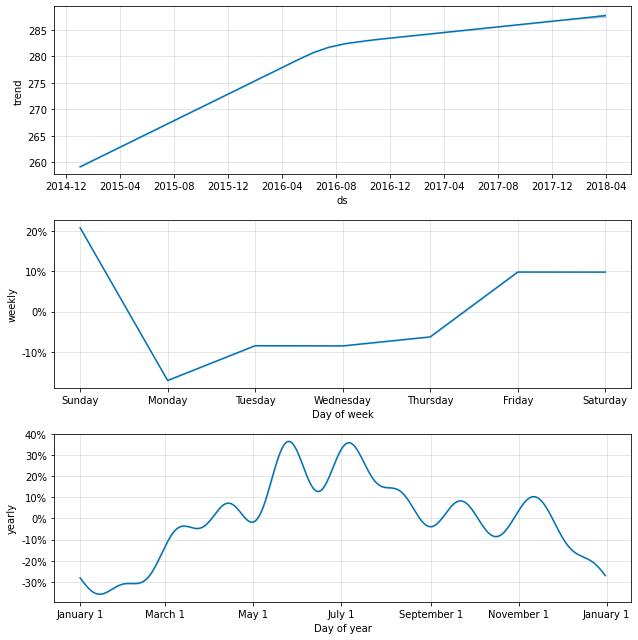

In [0]:
trends_fig = model.plot_components(forecast_pd)
display(trends_fig)

実際のデータと予測されたデータがどのように並んでいるかをグラフ化します。<br>
見やすくするために、過去1年の履歴データと予測結果のみに絞ります。

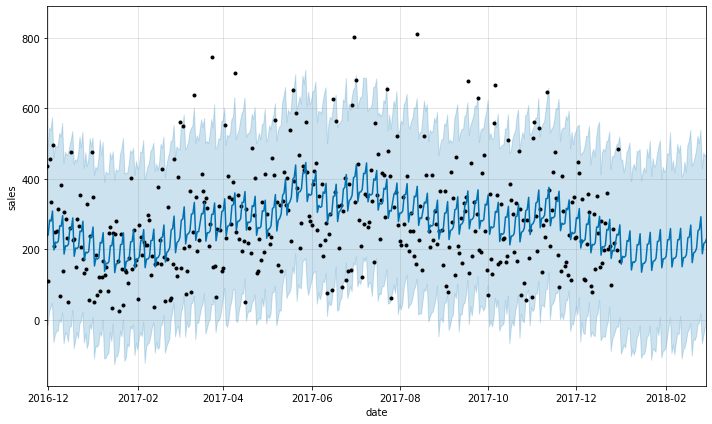

In [0]:
predict_fig = model.plot( forecast_pd, xlabel='date', ylabel='sales')

# 出力されるデータを過去1年と予測期間のみに絞る
xlim = predict_fig.axes[0].get_xlim()
new_xlim = ( xlim[1]-(180.0+365.0), xlim[1]-90.0)
predict_fig.axes[0].set_xlim(new_xlim)

display(predict_fig)

黒い点は実績を表し、濃い青色の線は予測値、明るい青の帯は95％の信頼性区間を表します。<br>
このグラフでは作成したモデルが良いモデルかどうかの判断を付けづらいので、以下を予測モデルの評価指標として用います<br>
<br>

**平均絶対誤差 (MAE: Mean Absolute Error)**<br>
各データにおいて実測値と予測値の誤差の絶対値を取り、平均をとったもの。<br>
RMSE に比べて外れ値の影響を受けにくいと言われる。

**平均二乗誤差 (MSE: Mean Squared Error)**<br>
誤差を二乗し、平均をとったもの

**二乗平均平方根誤差 (RMSE: Root Mean Squared Error)**<br>
MSE の平方根をとったもの。MAEに比べて大きな誤差を厳しく評価する特徴がある。

In [0]:
# DatetimeをDateに変換します
forecast_pd['ds'] = forecast_pd['ds'].dt.date

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from datetime import date

# 比較のために過去の実績と予測を取得
actuals_pd = aggregated_history_pd[ aggregated_history_pd['ds'] < date(2018, 1, 1) ]['y']
predicted_pd = forecast_pd[ forecast_pd['ds'] < date(2018, 1, 1) ]['yhat']

# 精度指標の計算
mae = mean_absolute_error(actuals_pd, predicted_pd)
mse = mean_squared_error(actuals_pd, predicted_pd)
rmse = sqrt(mse)

print('-----------------------------')
print( '\n'.join(['MAE: {0}', 'MSE: {1}', 'RMSE: {2}']).format(mae, mse, rmse) )

-----------------------------
MAE: 130.354504576387
MSE: 26501.053867522645
RMSE: 162.79144285718044

FBProphet を用いる際には、ここから更にチューニングし、モデルの精度を上げていくことがほとんどですが、今回はチューニングをスキップして、処理をスケーリングできるかどうかという課題に焦点を当てて、モデルを構築します。

## 4. モデル #2 - Prophet を用いて販売数予測 (店舗・アイテムの組み合わせ考慮)

上では、単一の時系列予測モデルを構築できることを示しましたが、次にApache Sparkの力を借りて、我々の能力を更に増強します。我々の目的は、データセット全体に対する単一の予測を行うことではなく、個々の製品・店舗の組み合わせに対して、数百のモデルを構築し予測を行うことです。通常、これを逐次的に実行した場合には、信じられないほど時間を要することになります。

データサイエンティストは、[Apache Spark](https://databricks.com/spark/about)の様な分散データ処理エンジンを使い、大量モデルをトレーニングするという課題に頻繁に取り組んでいます。Sparkクラスターを活用することで、クラスターにおける個々のワーカーノードは並列でモデルのサブセットを学習することができます。これにより、一連の時系列モデルの学習に要する時間を大幅に削減することができます。

もちろん、ワーカーノード(コンピューター)のクラスターにおけるモデル学習は、より多くのクラウドインフラストラクチャー及びそのコストを必要とします。しかし、オンデマンドでのクラウドリソースの高い可用性により、企業は必要に応じて迅速かつ柔軟にリソースを確保できます。これによって、自前で長い期間資産を持つことなしに、高いスケーラビリティを確保できます。

Sparkにおける分散データ処理の鍵となるメカニズムが[データフレーム](https://databricks.com/glossary/what-are-dataframes)です。データをSparkデータフレームに読み込むことで、データはクラスターにおけるノードに分散されます。これにより各ワーカーは並列でデータのサブセットを処理できる様になり、処理全体に要する時間を削減することできます。

データにおけるキーの値(本ケースでは店舗とアイテムの組み合わせ)に基づきグルーピングを行い、特定のワーカーノードにこれらのキー値に対応する時系列データを分配します。

今回利用しているデータセットは数10MBですので、処理速度がネックになることは考えにくいですが、実ビジネスでは、例えば天候データや各種イベントなども考慮に入れたうえで予測を行いたい、といったケースが出てきます。

以下では、ペタバイト級のデータセットにも対応可能にするために、スターバックスがとったアプローチでモデルを作成します。

In [0]:
sql_statement = '''
  SELECT
    store,
    item,
    date as ds,
    sales as y
  FROM
    history
  '''

store_item_history = (
  spark    
  .sql( sql_statement )
  .repartition(sc.defaultParallelism, ['store', 'item'])
).cache()

In [0]:
display(store_item_history)

store,item,ds,y
4,4,2013-01-01,13
4,4,2013-01-02,16
4,4,2013-01-03,12
4,4,2013-01-04,19
4,4,2013-01-05,13
4,4,2013-01-06,10
4,4,2013-01-07,13
4,4,2013-01-08,6
4,4,2013-01-09,16
4,4,2013-01-10,17


店舗/アイテム/日付レベルで集計されたデータを使用して、FBProphetにデータを渡す必要があります。そのデータをサブセットとしてモデルをトレーニング・予測する流れとなります。

予測結果は次のような構造のデータセットとして返されるものとします。

- `ds` 日付
- `store` 店舗ID
- `item` アイテムID
- `y` 実績値
- `yhat` 予測値
- `yhat_upper` 予測値上限
- `yhat_lower` 予測値下限

In [0]:
from pyspark.sql.types import *

result_schema =StructType([
  StructField('ds',DateType()),
  StructField('store',IntegerType()),
  StructField('item',IntegerType()),
  StructField('y',FloatType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])

店舗とアイテムに基づいて、適切に時系列データをグルーピングすることで、個々のグループに対してモデルを構築することができます。これを行うためには、pandasにおけるユーザー定義関数(UDF)を利用できます。これにより、データフレームにおける各グループに対して、カスタム関数を適用することが可能となります。

このUDFは、個々のグループに対してモデルをトレーニングするだけではなく、モデルから得られる予測値も取得します。この関数は個々のグループとは独立して、データフレームにおける各グループを学習・予測しますが、最終的な結果は一つのデータフレームにまとめる形となります。これにより、店舗・アイテムレベルでの予測を生成しつつも、結果を単一のデータセットとして分析者に提示することが可能になります。

In [0]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def forecast_store_item( history_pd ):
  
  # #1と同じロジックでモデルを作成
  # --------------------------------------
  # 欠損値を落とす(サブセットのデータ数によっては欠損値補完する必要あり)
  history_pd = history_pd.dropna()
  
  # モデル作成
  model = Prophet(
    interval_width=0.95,
    growth='linear', # linear or logistic
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
    )
  
  # モデル学習
  model.fit( history_pd )
  # --------------------------------------
  
  # #1と同じロジックで予測
  # --------------------------------------
  future_pd = model.make_future_dataframe(
    periods=90, 
    freq='d', 
    include_history=True
    )
  forecast_pd = model.predict( future_pd )  
  # --------------------------------------
  
  # サブセットを結合
  # --------------------------------------
  # 予測から関連フィールドを取得
  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')
  
  # 履歴から関連するフィールドを取得
  h_pd = history_pd[['ds','store','item','y']].set_index('ds')
  
  # 履歴と予測を結合
  results_pd = f_pd.join( h_pd, how='left' )
  results_pd.reset_index(level=0, inplace=True)
  
  # データセットから店舗と品番を取得
  results_pd['store'] = history_pd['store'].iloc[0]
  results_pd['item'] = history_pd['item'].iloc[0]
  # --------------------------------------
  
  # データセットを返す
  return results_pd[ ['ds', 'store', 'item', 'y', 'yhat', 'yhat_upper', 'yhat_lower'] ]  



モデリング・予測を各データセット(店舗・アイテムごとの各データセットで行っているので、<br>
最終的に予測結果を結合する処理を挟んでいますが、ベースとなる処理は#1のモデルとほとんど同じです。<br>
処理は標準的なpandasデータフレーム操作で構成されています。

In [0]:
from pyspark.sql.functions import current_date

results = (
  store_item_history    
  .groupBy('store', 'item') # 分割して予測したいカラムを定義
  .apply(forecast_store_item) # 先のセルで定義した関数を適用 (モデリングと予測)  <===== store, itemでGroupByしたDataframeに対して、上記のUDFを適用し、store, itemごとにprophetモデルを作成、推定している。
  .withColumn('training_date', current_date() ) # 予測を実行した日付のカラムを追加
)

results.createOrReplaceTempView('new_forecasts')

/databricks/spark/python/pyspark/sql/pandas/group_ops.py:81: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
 warnings.warn(

以下のクエリを発行することで、上記のモデリング・予測が実行されます。

In [0]:
%sql
SELECT * FROM new_forecasts

ds,store,item,y,yhat,yhat_upper,yhat_lower,training_date
2013-01-01,1,42,21.0,15.511226,25.47533,5.007558,2021-12-01
2013-01-02,1,42,24.0,16.085546,28.09886,4.4332504,2021-12-01
2013-01-03,1,42,14.0,17.332436,28.845037,6.0743737,2021-12-01
2013-01-04,1,42,22.0,18.92085,30.370779,8.250989,2021-12-01
2013-01-05,1,42,18.0,20.553915,31.746264,9.722219,2021-12-01
2013-01-06,1,42,26.0,22.346962,33.19904,11.303612,2021-12-01
2013-01-07,1,42,14.0,12.548618,24.31863,2.1690826,2021-12-01
2013-01-08,1,42,14.0,15.6055,26.654734,5.0463777,2021-12-01
2013-01-09,1,42,12.0,16.242304,27.014927,4.8581724,2021-12-01
2013-01-10,1,42,17.0,17.551523,27.828234,6.8460693,2021-12-01


予測結果をクエリできるように、テーブルとして保存します。多数のモデル構築を行うため、クラスターのスペックに依存しますが、処理には数分の時間を要します。

また、ここでは`using delta`を指定することで、Delta Lake形式でテーブルを作成しています。[Delta Lake](https://databricks.com/product/delta-lake-on-databricks)を活用することで、ペタバイトオーダーのデータに対しても、高い信頼性、高速な検索性能を付与することが可能となります。

In [0]:
%sql
drop table if exists forecasts;

-- create forecast table
create table if not exists forecasts (
  date date,
  store integer,
  item integer,
  sales float,
  sales_predicted float,
  sales_predicted_upper float,
  sales_predicted_lower float,
  training_date date
  )
using delta
partitioned by (training_date);

-- load data to it
insert into forecasts
select 
  ds as date,
  store,
  item,
  y as sales,
  yhat as sales_predicted,
  yhat_upper as sales_predicted_upper,
  yhat_lower as sales_predicted_lower,
  training_date
from new_forecasts;

num_affected_rows,num_inserted_rows
958000,958000


1のモデルと同じようにモデルを評価する必要がありますが、<br>
ここでもpandas UDF を利用することで店舗・アイテムごとに評価指標を算出できます。

In [0]:
import pandas as pd

# 評価指標のカラム定義
eval_schema =StructType([
  StructField('training_date', DateType()),
  StructField('store', IntegerType()),
  StructField('item', IntegerType()),
  StructField('mae', FloatType()),
  StructField('mse', FloatType()),
  StructField('rmse', FloatType())
  ])

# 評価指標の算出
@pandas_udf( eval_schema, PandasUDFType.GROUPED_MAP )
def evaluate_forecast( evaluation_pd ):
  
  # データセットのストアとアイテムを取得
  training_date = evaluation_pd['training_date'].iloc[0]
  store = evaluation_pd['store'].iloc[0]
  item = evaluation_pd['item'].iloc[0]
  
  # 評価指標を算出
  mae = mean_absolute_error( evaluation_pd['y'], evaluation_pd['yhat'] )
  mse = mean_squared_error( evaluation_pd['y'], evaluation_pd['yhat'] )
  rmse = sqrt( mse )
  
  # 結果を結合
  results = {'training_date':[training_date], 'store':[store], 'item':[item], 'mae':[mae], 'mse':[mse], 'rmse':[rmse]}
  return pd.DataFrame.from_dict( results )

In [0]:
# calculate metrics
results = (
  spark
    .table('new_forecasts')
    .filter('ds < \'2018-01-01\'') # 評価を履歴データ(正解ラベル)がある期間に制限
    .select('training_date', 'store', 'item', 'y', 'yhat')
    .groupBy('training_date', 'store', 'item')
    .apply(evaluate_forecast)
    )
results.createOrReplaceTempView('new_forecast_evals')

評価指標もクエリ可能なテーブルに永続化しておきます。

In [0]:
%sql

drop table if exists forecast_evals;

create table if not exists forecast_evals (
  store integer,
  item integer,
  mae float,
  mse float,
  rmse float,
  training_date date
  )
using delta
partitioned by (training_date);

insert into forecast_evals
select
  store,
  item,
  mae,
  mse,
  rmse,
  training_date
from new_forecast_evals;

num_affected_rows,num_inserted_rows
500,500


これで、ストアとアイテムの組み合わせごとに予測を作成し、それぞれの基本的な評価指標を生成できました。<br>
対象を製品1に限定し、店舗1から店舗10それぞれの予測結果を見てみます。

In [0]:
%sql select count(*) from forecasts

count(1)
958000


In [0]:
%sql select * from forecasts where item = 1 and date >= '2018-01-01'  order by date desc limit 30

date,store,item,sales,sales_predicted,sales_predicted_upper,sales_predicted_lower,training_date
2018-03-31,9,1,null,31.243073,40.627094,21.993523,2021-12-01
2018-03-31,2,1,null,37.044247,47.92993,26.448792,2021-12-01
2018-03-31,7,1,null,19.707716,27.018166,12.082905,2021-12-01
2018-03-31,3,1,null,34.407127,43.838043,24.632668,2021-12-01
2018-03-31,1,1,null,25.806086,34.883156,17.600426,2021-12-01
2018-03-31,6,1,null,22.235483,30.0766,13.955686,2021-12-01
2018-03-31,10,1,null,31.956638,41.590706,21.651701,2021-12-01
2018-03-31,5,1,null,20.536674,28.767666,12.5065775,2021-12-01
2018-03-31,8,1,null,34.646626,45.562206,23.946787,2021-12-01
2018-03-31,4,1,null,27.731651,37.102325,18.645737,2021-12-01


In [0]:
%sql select current_date() -1 

"date_sub(current_date(), 1)"
2021-12-01


In [0]:
%sql

SELECT
  store,
  date,
  sales_predicted,
  sales_predicted_upper,
  sales_predicted_lower
FROM forecasts a
WHERE item = 1 AND
      -- store IN (1, 2, 3, 4, 5) AND
      date >= '2018-01-01' AND
      training_date>=current_date() - 7
ORDER BY store

store,date,sales_predicted,sales_predicted_upper,sales_predicted_lower
1,2018-01-28,20.70674,28.897345,11.7943735
1,2018-02-26,12.426637,20.739134,3.903884
1,2018-01-07,20.750635,29.042006,11.985569
1,2018-02-27,15.563532,24.331827,7.5427127
1,2018-01-29,11.460116,19.147371,2.0077267
1,2018-02-28,16.381023,25.509508,7.8635526
1,2018-03-01,17.30198,25.508818,8.691121
1,2018-01-15,10.79329,19.11797,2.1918614
1,2018-01-30,14.580006,22.814817,6.5722375
1,2018-03-02,19.224846,27.30746,10.7036295


アイテム#1について、店舗ごとの予測の精度指標を見てみます。

In [0]:
%sql

SELECT
  store,
  mae,
  mse,
  rmse
FROM forecast_evals a
WHERE item = 1 AND
      training_date=current_date()
ORDER BY store

store,mae,mse,rmse
1,3.4864485,19.388842,4.4032764
2,4.234534,27.934034,5.285266
3,3.9922068,25.207825,5.0207396
4,3.8169012,23.144577,4.810881
5,3.2822154,17.39446,4.1706667
6,3.2112038,16.17285,4.0215483
7,3.0864716,15.590087,3.9484284
8,4.307357,30.421188,5.5155406
9,3.8268247,23.397783,4.8371253
10,3.9558375,25.307636,5.0306697


以下はモデル#1 (店舗とアイテムの組み合わせを考慮しない場合) の精度指標です。<br>
全てのアイテムについて確認していないので断定はできませんが、細かい粒度での予測ができるようになりました。

In [0]:
print( '\n'.join(['MAE: {0}', 'MSE: {1}', 'RMSE: {2}']).format(mae, mse, rmse) )

MAE: 130.354504576387
MSE: 26501.053867522645
RMSE: 162.79144285718044

## 参考情報

- [スターバックスにおける事例：Facebook Prophet と Azure Databricks を利用した大規模な需要予測 \- Databricks](https://databricks.com/jp/p/webinar/starbucks-forecast-demand-at-scale-facebook-prophet-azure-databricks)
- [Time Series Forecasting With Prophet And Spark \- Databricks](https://databricks.com/blog/2020/01/27/time-series-forecasting-prophet-spark.html)
- [Fine Grained Demand Forecasting \- Databricks](https://pages.databricks.com/rs/094-YMS-629/images/Fine-Grained-Time-Series-Forecasting.html)